In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



A video shows a men part of ISIS beheading another person. The question is identity. The man in the video has a pair of missing fingers. A suspect is identified, has missing fingers and matches other characteristics (travelled to Syria, participated in ISIS etc.). Suspect denies beheading the person in the video.

Key identification evidence:

    suspect's missing fingers are missing in the same places as the missing fingers of the person in the video.
    probability of random match in Swedish population based on police database is assessed to be 2/20,000
    only 2 matches in 20,000 entry database
    matching fingers of people in database are of people who died at the time of the crime

Missing evidence:

    database is based on Swedish population, not ISIS members, random match probability could have been different

Suspect is acquitted or charges because evidence was not robust

Interesting quotation:
"The court explains that a random match probability of 1 in 10 000 would have been sufficient for proof beyond
reasonable doubt, given the other circumstances of the case, if this probability had
been robust, but in the absence of more reference data on people affiliated with ISIS it
is not sufficiently robust for the standard of proof in criminal cases." (p. 142)

Weight question in this case:

    Had an ISIS database been available at trial, how would the overall evidence have changed?


In [8]:
def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins = 20):

    """
   The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
    and plots histograms for specified nodes. The function then returns the processed DataFrame.
    Parameters:
    - nodes: Dictionary of nodes containing data.
    - filters: Optional dictionary to filter the data based on specified conditions.
    - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
    - bins: Number of bins for the histograms (default is 20).

    Returns:
    - DataFrame of the processed values.
    """

    values = {key: nodes[key]['value'].float().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color='blue', density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF

In [3]:
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1)
    entropy_uniform = entropy(uniform, base=base)
    entropy_posterior = entropy(posterior, base=base)
    return 1 - entropy_posterior/entropy_uniform


The function above calculates weight of evidence of a posterior $p$ in a following manner, where H is $H = -\sum p \log(p)$:$$ W(p) = 1 - \frac{H(p)}{H(\text{uniform})} $$

In [ ]:
def fingers_model_just_sweden():
    """

    fingers_model_just_sweden is a model defined as a function in Pyro. 
    Each line defines a variable


    """

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1, 1))
    # a value sampled from a beta distribution 

    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))
    
    pr_fingers_if_swedish = pyro.sample("pr_fingers_if_swedish", dist.Beta(3, 20001))

    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + (1 - guilty) * pr_fingers_if_swedish)
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))







pyro.render_model(fingers_model_just_sweden)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model_just_sweden()

nodes = tr.trace.nodes



plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["pr_fingers_if_swedish", "guilty"])


In [24]:
prob_guilty = pyro.sample("prob_guilty", dist.Beta(1, 1))
prob_guilty

tensor(0.5841)

In [5]:
2/20000 * 100

0.01

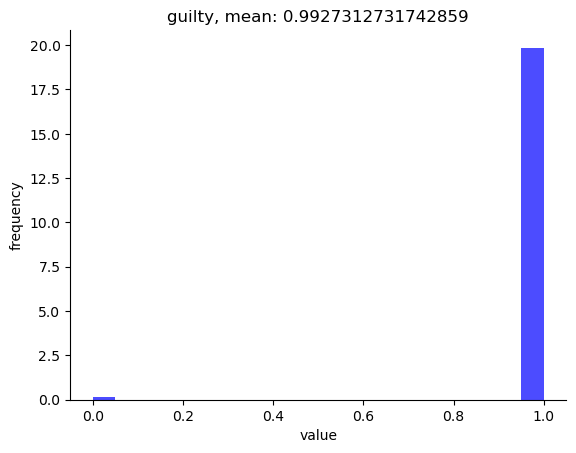

Weight of evidence for guilt: 0.9379140200085901


In [6]:
def fingers_model():

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1,1))  # this is unrealistically and extremely charitable if set to 1,1 as it means we have no prior belief about isis fighters torturing and killing people, while it was part of their modus operandi

    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))

    pr_fingers_if_swedish = pyro.sample("pr_fingers_if_swedish", dist.Beta(3, 20001))

    pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis", dist.Uniform(pr_fingers_if_swedish, (100 * pr_fingers_if_swedish).clamp(0, 1)))  # charitably, chance of fingers if in isis 
     
    #pr_fingers_if_isis =  0.01                                                                                                                                      # 50 times higher than if merely swedish  

    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + 
                                        (1 - guilty) * pr_fingers_if_isis)
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))

pyro.render_model(fingers_model)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model()

nodes = tr.trace.nodes
df = plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["guilty"])

posterior_guilt =  [df['guilty'].mean(), 1 - df['guilty'].mean()]
print(f"Weight of evidence for guilt: {weight(posterior_guilt)}")


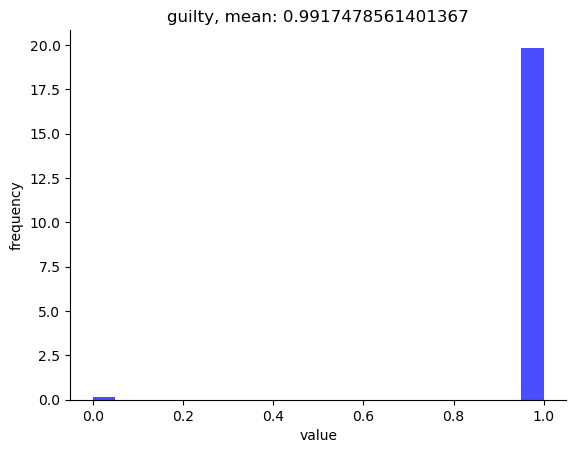

Weight of evidence for guilt: 0.9310307168773658


In [7]:
def fingers_model():

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1, 1))  # this is unrealistically and extremely charitable if set to 1,1 as it means we have no prior belief about isis fighters torturing and killing people, while it was part of their modus operandi

    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))

    pr_fingers_if_swedish = pyro.sample("pr_fingers_if_swedish", dist.Beta(3, 20001))

    pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis",  dist.Beta(8, 1001))  # charitably, chance of fingers if in isis

    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + 
                                        (1 - guilty) * pr_fingers_if_isis)
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))

pyro.render_model(fingers_model)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model()

nodes = tr.trace.nodes
df = plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["guilty"])

posterior_guilt =  [df['guilty'].mean(), 1 - df['guilty'].mean()]
print(f"Weight of evidence for guilt: {weight(posterior_guilt)}")